## Подключение к Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from bs4 import BeautifulSoup
from random import shuffle
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.matutils import unitvec
import gensim.models.keyedvectors as Word2vec

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Скачивание и исследование данных





In [ ]:
data = pd.read_csv("/content/drive/MyDrive/IMDB_Dataset.csv", engine="python", error_bad_lines=False)
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
print("Количество токенов в корпусе:")
data['review'].apply(lambda x: len(x.split(' '))).sum()

Количество токенов в корпусе:


11557297

Распределение по категориям


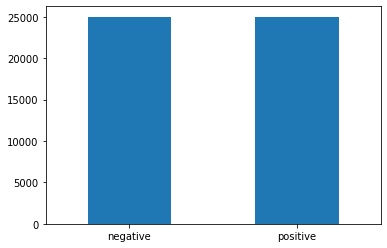

In [ ]:
print("Распределение по категориям")
data['sentiment'].value_counts().plot(kind="bar", rot=0)

In [ ]:
AMOUNT_DATA = 50000

docs = data['review']
scores = data['sentiment']

docs = docs[:AMOUNT_DATA]
scores = scores[:AMOUNT_DATA]

scores = pd.factorize(scores)[0]
docs[:5]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [ ]:
scores[:5] # 0 -pos 1 - neg

array([0, 0, 0, 1, 0])

## Стемматизация корпуса (необязательно)

Стемматизированный корпус сохраним на диске

In [ ]:
%%time
ps = PorterStemmer()

for n,doc in enumerate(docs):
    new_doc = ''
    s_w = {'film', 'movi'}
    words = word_tokenize(doc)
    for w in words:
        w = ps.stem(w)
        if not (w in s_w):
            new_doc += w + ' '
    docs[n] = new_doc

docs[:5]
docs.to_csv('/content/drive/MyDrive/StemmerCorpus')

Скачиваем стемматизированный корпус с диска

In [ ]:
docs = pd.read_csv("/content/drive/MyDrive/StemmerCorpus")['review']
docs[:5]

0    one of the other review ha mention that after ...
1    A wonder littl product . < br / > < br / > the...
2    I thought thi wa a wonder way to spend time on...
3    basic there 's a famili where a littl boy ( ja...
4    petter mattei 's `` love in the time of money ...
Name: review, dtype: object

# Bag of words и TF-IDF + Classifier

### Разделения корпуса текста на тренировочный и тестовый набор

In [ ]:
docs_train, docs_test, y_train, y_test = train_test_split(docs, scores,
                                                          test_size=0.10, random_state=None)

In [ ]:
print(docs_train.shape, y_train.shape)
print(docs_test.shape, y_test.shape)

(45000,) (45000,)
(5000,) (5000,)


In [ ]:
#очистка данных от тех. символов
docs_test = docs_test.apply(lambda x: BeautifulSoup(x).get_text())
docs_train = docs_train.apply(lambda x: BeautifulSoup(x).get_text())

Распределение по категориям в тестовом наборе


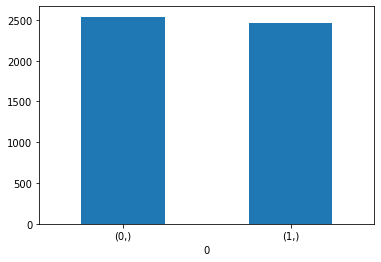

In [ ]:
print("Распределение по категориям в тестовом наборе")
pd.DataFrame(y_test).value_counts().plot(kind="bar", rot=0)

### Написание эстиматора-переключателя
Используеться как универсальная модель, которая может быть любой моделью машинного обучения из sklean, в зависимости от параметра. Используеться при обучения по сетке, для выбора лучшей модели машинного обучения

In [ ]:
class ClfSwitcher(BaseEstimator): # Модель - переключатель
    def __init__(self, estimator = SGDClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

    def coef(self):
        return self.estimator.coef_


### Написание Pipeline

#### Bag of word
Каждый документ - это вектор размером с весь словарь корпуса, при том каждый элемент вектора сооветвует одному слову из словаря. И он равен одному, если это слово есть в данном документе, иначе ноль.
Таким оброзом мы преобразуем документы в векторы

#### Tf-idf
TF (или частота слова) – это отношение количества употреблений какого-либо слова к совокупному количеству слов документа. Следовательно, анализируется значимость слова в одном отдельном документе.
IDF — это обратная частотность документов, с которой какое-либо слово упоминается в документах коллекции. Для любого уникального слова в пределах точной коллекции документов присутствует одно значение IDF.
TF-IDF считается произведением двух выражений.
Т.е TF-IDF учитывает важность слова не только в рамках документа, но и рамках всего корпуса.


In [ ]:
pipeline_bag_of_word = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),
        ('clf', ClfSwitcher())
])

pipeline_tf_idf = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),
        ('tf-idf', TfidfTransformer()),
        ('clf', ClfSwitcher())
])

#### Составляем сетку параметров

In [ ]:
parameters = [
    {
    #Линейный классифектор
        'clf__estimator': [SGDClassifier()], # SVM == loss
    #Парметры векторизации
        'vect__ngram_range': [(1, 1), (1, 2)],
        'vect__max_features': [None, 3000, 5000],
        'vect__min_df': [1,2],
    #Параметры модели
        'clf__estimator__max_iter': [30,50,80],
        'clf__estimator__alpha': [0.001, 0.0001],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
     #K-ближайших соседей
        'clf__estimator': [KNeighborsClassifier(n_jobs=-1)],
     #Парметры векторизации
        'vect__ngram_range': [(1, 1), (1, 2)],
        'vect__max_features': [None, 3000, 5000],
        'vect__min_df': [1,2],
     #Параметры модели
        'clf__estimator__n_neighbors':[3, 5],
        'clf__estimator__metric':['minkowski', 'cosine']
    },
    {
     #Решающие деревья
        'clf__estimator': [RandomForestClassifier(n_jobs=-1)],
     #Парметры векторизации
        'vect__ngram_range': [(1, 1), (1, 2)],
        'vect__max_features': [None, 3000, 5000],
        'vect__min_df': [1,2],
     #Параметры модели
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth':[3, 5, 10]
    }
]
#(?u)\b\w\D\w+\b - без цифр.

### Обучение пиплайнов по сетке параметров

In [ ]:
%%time
grid_search = GridSearchCV(pipeline_tf_idf, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

### Сохраняеям модель в файле

In [ ]:
filename = '/content/drive/MyDrive/model.sav'

In [ ]:
import pickle
filename = '/content/drive/MyDrive/model.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
-+
grid_search = pickle.load(open(filename, "rb"))

### Анализ модели

Лучшие параметры для веторизатора и классификатора

In [ ]:
grid_search.best_params_

{'clf__estimator': SGDClassifier(alpha=0.001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
               max_iter=80, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'clf__estimator__alpha': 0.001,
 'clf__estimator__loss': 'modified_huber',
 'clf__estimator__max_iter': 80,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1)}

In [ ]:
res = (
    pd.DataFrame({
        "mean_test_score": grid_search.cv_results_["mean_test_score"],
        "mean_fit_time": grid_search.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_search.cv_results_["params"]).add_prefix("param_"))
)
res = res.to_csv() # перевоести в cvs file
file_res = open("/content/drive/MyDrive/baseline_result.txt", "w")
file_res.write(res)

### Интепритация модели
Плюсом линейной модели является её прозрачность.
Оценив её коэффициенты(а их столько, сколько токенов в словаре после векторизации) - мы можем сказать какие слова влияют сильнее на результат, т.е те слова по которым алгоритм классифицирует документы



Функция, которая выводит 10 токенов, которым соответствуют самые большие коэффициенты



In [ ]:
def most_influential_words(features, coefs, num_words=10):
    max_coef = sorted(enumerate(coefs), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

Получаем токены в словаре

In [ ]:
features = gs_model.best_estimator_.named_steps['vect'].get_feature_names()
print("Кол-во токенов в словаре: ",len(features))
features[1000:1010]

Кол-во токенов в словаре:  16608


['aspect',
 'aspects',
 'aspirants',
 'aspiration',
 'aspire',
 'aspiring',
 'ass',
 'assante',
 'assasain',
 'assassain']

Получаем коэффициенты лин. модели

In [ ]:
if isinstance(gs_model.best_params_.get('clf__estimator'), SGDClassifier):
    coefs = gs_model.best_estimator_.named_steps['clf'].coef()
print("Размер матрицы коеф. лин. классиф:",coefs.shape)
list(coefs[0])[1000:1010]

Размер матрицы коеф. лин. классиф: (1, 16608)


[-0.00222830121740366,
 -0.33928795239928083,
 -0.0030437983461040247,
 0.03041990184680768,
 -0.05208349007914627,
 0.0272305504071982,
 -0.06479012853681851,
 0.08000766095690182,
 -0.05836563365522124,
 -0.05836563365522124]

Выводим 10 самых значимых слов для классификации

---



In [ ]:
# Самые важные слова для модели
most_influential_words(features,list(coefs[0]))

['bad',
 'worst',
 'awful',
 'waste',
 'instead',
 'just',
 'boring',
 'poor',
 'stupid',
 'money']

## Оцена модели на тестовом наборе

In [ ]:
y_predicted = grid_search.predict(docs_test)
print(metrics.classification_report(y_test, y_predicted,
                                        target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        51
           1       0.76      0.76      0.76        49

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



[[39 12]
 [12 37]]


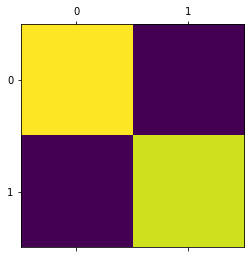

In [ ]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)
plt.matshow(cm)
plt.show()

# Предобученный Word2Vec

## Что такое Word2Vec?
Word2vec это способ векторизации при, котором вектора отражают семантические взаимосвязи слов.
 
Один из основных алгоритм обучения Word2Vec - это CBoW.
В этой архитектуре окно(размер - гиперпараметр) скользит по тексту и в окне выделяться центральное слово, которая нейронная сеть пытаются предсказать, используя контекст - слова которые находяться рядом.
Таким образом, нейронная сеть пытаются предсказать слово по его контексту.
Задача, в итоге сводиться к максимизации произведения веротности каждого контекстного слова получить центральное.
 
С этой задачей отлично справляется нейронная сеть со скрытым слоем.
В этом скрытом слое после обучения и будут храниться векторные представления слов.
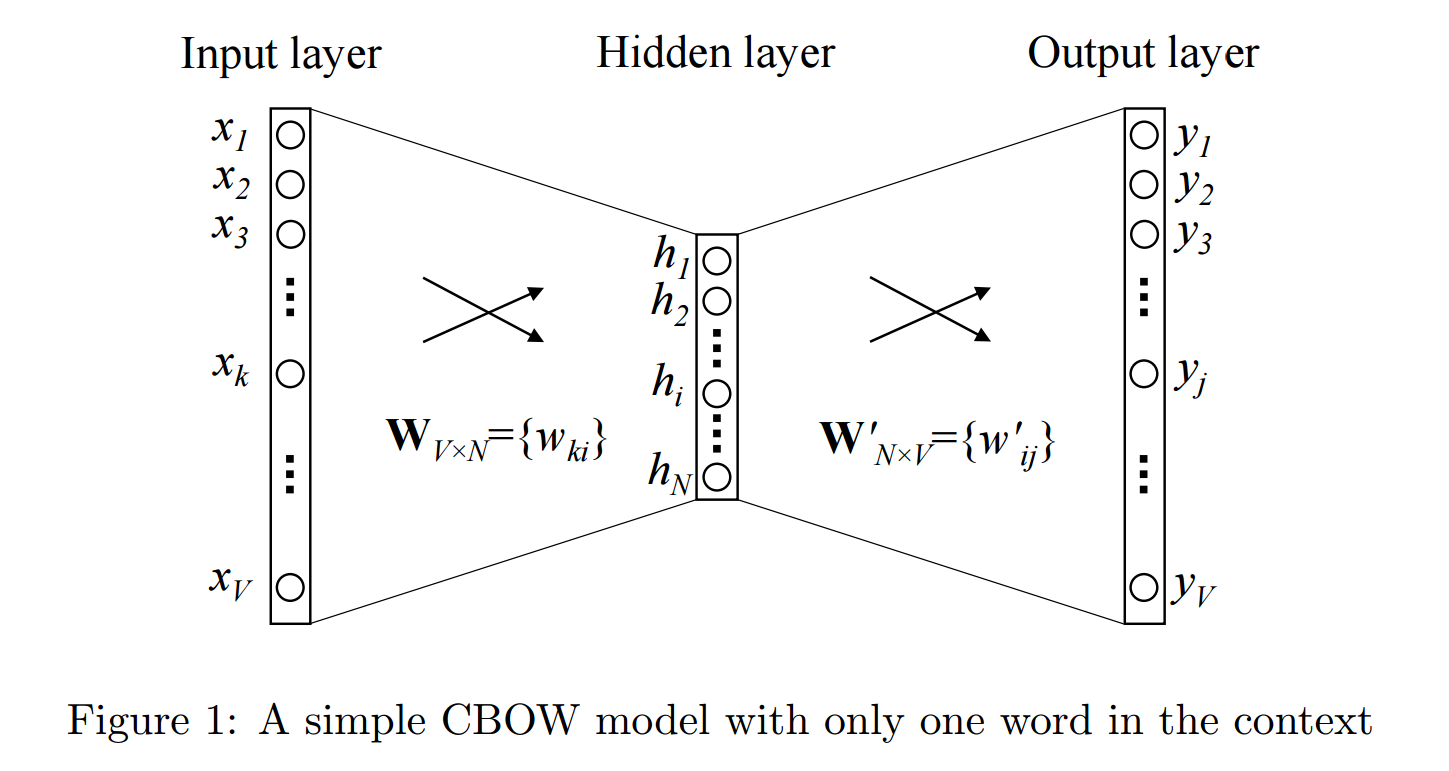


Слова на вход нейронной сети подаються в виде one-hot векторов.

## Предобученный word2vec от Google

Так как обучать Word2Vec на больших данных затруднительно, то существуют предобученные представления слов - которые обычно обучены на очень больших данных.
Потому используя такие модели - можно сэкономить время нужное для векторизации и получить часто хорошие результаты


В качестве предобученного Word2Vec возьмем классический набор от Google, который обучен на статьях из интернета. В общей сложности эта модель обучена на 300 млд токенов. Word2Vec состоит из токенов и векторов размером 300, которые соответствуют этим токенам.
### Скачаем эту предобученную модель

In [ ]:
%%time
wv = Word2vec.KeyedVectors.load_word2vec_format(
    "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

CPU times: user 2min 53s, sys: 6.8 s, total: 3min
Wall time: 3min 8s


In [ ]:
wv.most_similar('war')

[('wars', 0.748465895652771),
 ('War', 0.6410670280456543),
 ('invasion', 0.5892110466957092),
 ('Persian_Gulf_War', 0.5890660285949707),
 ('Vietnam_War', 0.5886474847793579),
 ('Iraq', 0.588599443435669),
 ('unwinnable_quagmire', 0.5681803226470947),
 ('un_winnable', 0.560634970664978),
 ('occupation', 0.5506216287612915),
 ('conflict', 0.5506188273429871)]

In [ ]:
wv.most_similar('Russia')

[('Ukraine', 0.7918288111686707),
 ('Moscow', 0.7575765252113342),
 ('Russian', 0.7464962005615234),
 ('Belarus', 0.7303562164306641),
 ('Kremlin', 0.7048990726470947),
 ('Kazakhstan', 0.6979326605796814),
 ('Russians', 0.677611231803894),
 ('Biologist_Anatoly_Kochnev', 0.6745501160621643),
 ('Azerbaijan', 0.6726992726325989),
 ('Putin', 0.6636874079704285)]

### Как объединить вектора?
Так как наш документ состоит из многих токенов, а каждый токен будет представлен вектором размером 300, то встаёт вопрос, как объединить эти вектора, чтобы они представляли документ.
Самое эффективное решение - это просто сложить все вектора в одном документе и поделить на кол-во векторов в этом документе. Так мы получим усредненное представление о документе.

 

### Токенизация
Так как в базе от гугл слова учитывают регистр, то токенизировать нужно так же НЕ приводя все к нижнему регистру

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2: #токены размером менее 2-х символов не учитываем
                continue
            if word in stopwords.words('english'): # стоп слова не учитываем
                continue
            tokens.append(word)
    return tokens

In [ ]:
test_tokenized = docs_test.apply(lambda r: w2v_tokenize_text(r)).values
train_tokenized = docs_train.apply(lambda r: w2v_tokenize_text(r)).values

In [ ]:
test_tokenized[:5]

array([list(['This', 'short', 'film', 'inspired', 'soon-to-be', 'full', 'length', 'feature', 'Spatula', 'Madness', 'hilarious', 'piece', 'contends', 'similar', 'cartoons', 'yielding', 'multiple', 'writers', 'The', 'short', 'film', 'stars', 'Edward', 'Spatula', 'fired', 'job', 'joins', 'fight', 'evil', 'spoons', 'This', 'premise', 'allows', 'funny', 'content', 'near', 'beginning', 'barely', 'present', 'remainder', 'feature', 'This', 'film', "'s", '15-minute', 'running', 'time', 'absorbed', 'odd-ball', 'comedy', 'small', 'musical', 'number', 'Unfortunately', 'much', 'else', 'lies', 'The', 'plot', 'set', "n't", 'really', 'time', 'show', 'But', "'s", 'surely', 'follows', 'plot', 'better', 'many', 'high-budget', 'Hollywood', 'films', 'This', 'film', 'worth', 'watching', 'least', 'times', 'Take', "n't", 'expect', 'deep', 'story']),
       list(['It', "n't", 'happen', 'often', 'occasionally', 'one', 'man', 'make', 'difference', '--', 'big', 'difference.George', 'Crile', "'s", '2003', 'best', 

### Перевод токенов в векторы и усреднение
Следующие функции, ищут для каждого токена в документе, такой же токен в базе Word2Vec и меняют на соответствующий ему вектор.
Если, токен в базе не найден, его просто пропускают.
Далее, для каждого документа усредняют все вектора.
В итоге каждому документу будет соответствовать токен размером 300
 



In [ ]:
def document_averaging(wv, words):
    #all_words = set()
    mean = []
    
    for word in words:
        if isinstance(word, np.ndarray): #если слово уже представленно в вектрной форме
            mean.append(word)
        elif word in wv.vocab: #иначе ищем слово в нашей предобученной базе
            mean.append(wv.syn0norm[wv.vocab[word].index]) # добавить в mean нормализованный вектор
            #all_words.add(wv.vocab[word].index)

    if not mean:
        print("В документе нет слов из предобученной базы%s", words)
        return np.zeros(wv.layer1_size,) # В этом случае вернем нулевой вектор

    mean = unitvec(np.array(mean).mean(axis=0)).astype(np.float32) # усредняем вектора
    return mean

In [ ]:
def corpus_vectorize(wv, text_list):
    return np.vstack([document_averaging(wv, review) for review in text_list ])

In [ ]:
%%time
X_train_word_average = corpus_vectorize(wv,train_tokenized)
X_test_word_average = corpus_vectorize(wv,test_tokenized)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if __name__ == '__main__':


In [ ]:
print("Test ", X_test_word_average.shape)
print("Train ", X_train_word_average.shape)
X_test_word_average[:10]

Test  (100, 300)
Train  (900, 300)


array([[ 0.01511425,  0.05774714, -0.00480706, ..., -0.03070359,
         0.02221176, -0.04859292],
       [ 0.04916461,  0.04138976, -0.00734687, ..., -0.0630651 ,
         0.04854797,  0.0105641 ],
       [ 0.08379324,  0.02860234, -0.01590703, ..., -0.05149863,
         0.01923489, -0.00306875],
       ...,
       [ 0.05629408,  0.06181437,  0.01504644, ..., -0.01784205,
         0.04390616, -0.04075214],
       [ 0.08985061,  0.07480986, -0.01807079, ..., -0.05890295,
         0.04971485,  0.02854544],
       [ 0.04300767,  0.0554245 ,  0.00320187, ..., -0.04623767,
         0.07148967,  0.01956834]], dtype=float32)

### Обучеаем пиплайн на полученных данных 

In [ ]:
pipeline_avrg_word_2_vec = Pipeline([
        ('clf', ClfSwitcher())
])

In [ ]:
parameters = [
    {
    #Линейный классифектор
        'clf__estimator': [SGDClassifier()], # SVM == loss
        'clf__estimator__max_iter': [30,50,80],
        'clf__estimator__alpha': [0.001, 0.0001],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
     #K-ближайших соседей
        'clf__estimator': [KNeighborsClassifier(n_jobs=-1)],
        'clf__estimator__n_neighbors':[3, 5],
        'clf__estimator__metric':['minkowski', 'cosine']
    },
    {
     #Решающие деревья
        'clf__estimator': [RandomForestClassifier(n_jobs=-1)],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth':[3, 5, 10]
    }
]

In [ ]:
%%time
grid_search = GridSearchCV(pipeline_avrg_word_2_vec, parameters, n_jobs=-1)
grid_search.fit(X_train_word_average, y_train)

In [ ]:
grid_search.best_params_

{'clf__estimator': SGDClassifier(alpha=0.001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
               max_iter=30, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'clf__estimator__alpha': 0.001,
 'clf__estimator__loss': 'modified_huber',
 'clf__estimator__max_iter': 30}

In [ ]:
res = (
    pd.DataFrame({
        "mean_test_score": grid_search.cv_results_["mean_test_score"],
        "mean_fit_time": grid_search.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_search.cv_results_["params"]).add_prefix("param_"))
)
res = res.to_csv() # перевоести в cvs file
file_res = open("/content/drive/MyDrive/word2vec_result.txt", "w")
file_res.write(res)

In [ ]:
y_predicted = grid_search.predict(X_test_word_average)
print(metrics.classification_report(y_test, y_predicted,
                                        target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75        36
           1       0.88      0.81      0.85        64

    accuracy                           0.81       100
   macro avg       0.79      0.81      0.80       100
weighted avg       0.82      0.81      0.81       100



# Реализация Doc2Vec
Doc2Vec это модификация Word2Vec созданная для того чтобы переводить целый документ в вектор, а не отдельное слово.
Отличие модели состоит в том, что мы подсказывая слова по контексту учитываем не только слово, но и тэг документа, в нашем случае 2 тэга - positive, negative.
Схема нерйонной сети выглядит так:
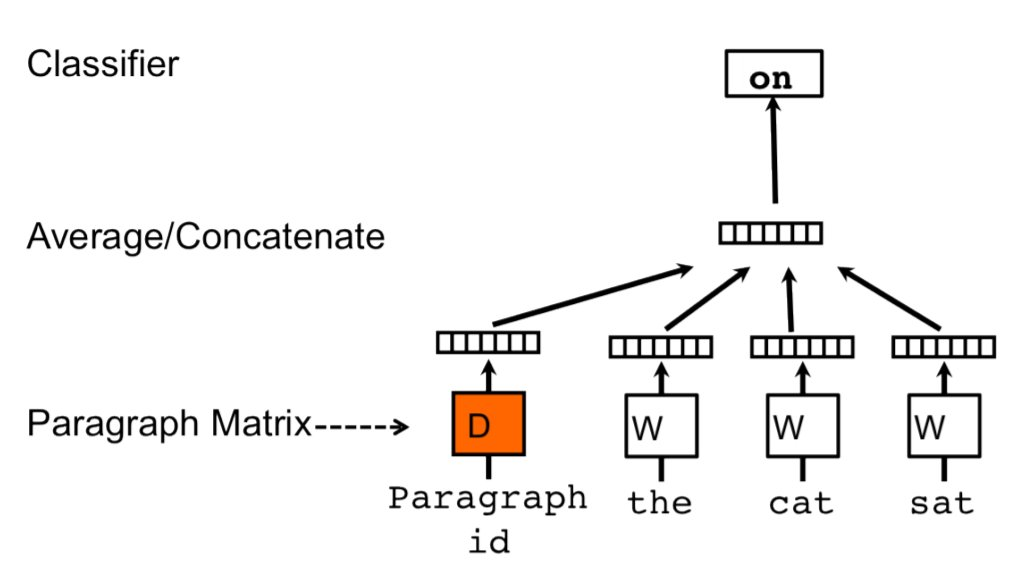

Paragraph Id - и есть тэг документа.
При том тэг документа это тоже вектор из того же пространства, что и слова.
В итоге Doc2Vec учиться предсказывать слова по контексту и по тэгу этого документа.
Формула выглядит так:

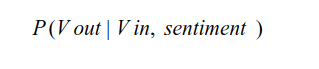


Где, Vout - предсказываемые слово,  Vin - слово из  контекста, sentiment - тэг документа, в наше случае { positive negative },

### Функция для токенизации
В этот раз токенизируем без учета регистра

In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower()) # в этом случае приводим к нижнему регистру
    return tokens

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
print("Test data shape ",test_data.shape)
print("Train data shape ",train_data.shape)

Test data shape  (5000, 2)
Train data shape  (45000, 2)


### Предствление данных в нужном виде
TaggedDocument - это специльный тип данных применямый в библиотеке Gensim.
Имеет слеудующую структуру:
`TaggedDocument(words=['word1','word2', ..., 'wordn'], tags=['doc_tag'])`


In [ ]:
%%time
train_tagged = train_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r['sentiment']]), axis=1)
test_tagged = test_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r['sentiment']]), axis=1)

In [ ]:
type(train_tagged)

pandas.core.series.Series

In [ ]:
train_set = train_tagged.values
test_set = test_tagged.values
print(type(train_set))
train_set[2]

<class 'numpy.ndarray'>


TaggedDocument(words=['remember', 'loved', 'this', 'movie', 'when', 'it', 'came', 'out', 'was', '12', 'years', 'old', 'had', 'commodore', '64', 'and', 'loved', 'to', 'play', 'rambo', 'on', 'it', 'was', 'therefore', 'really', 'thrilled', 'when', 'got', 'to', 'buy', 'this', 'movie', 'really', 'cheap', 'put', 'it', 'in', 'my', 'vcr', 'and', 'started', 'up', 'man', 'this', 'movie', 'is', 'really', 'bad', 'sylvester', 'stallone', 'says', 'like', 'words', 'in', 'the', 'entire', 'movie', 'except', 'for', 'that', 'awful', 'sentimental', 'speech', 'at', 'the', 'end', 'and', 'has', 'the', 'same', 'expression', 'on', 'his', 'face', 'all', 'the', 'way', 'and', 'that', 'stupid', 'love', 'thing', 'in', 'the', 'middle', 'it', "'s", 'just', 'so', 'amazingly', 'predictable', 'just', 'ended', 'up', 'fast', 'forwarding', 'the', 'entire', 'thing', 'and', 'went', 'to', 'exchange', 'the', 'movie', 'for', 'something', 'else'], tags=['negative'])

### Создаем Doc2vec модель

Doc2Vec - модель в Gensim. В качестве параметров передаем размер векторов, равный 100, кол-во эпох для обучений - 10, кол-во параллельных потоков - 4, и порог, токены, длина которых меньше потока не учитывается, поставим 2.

*Заметим, что словарь мы строим только на учебной выборке, потому что, Doc2Vec модель учитываем в своем построении лейблы. Соответственно, учитывая тестовую выборку мы бы получили "нечестный" результат.*

In [ ]:
%%time
doc2vec_model = Doc2Vec(vector_size=100, epoch=10, workers=4, min_count=2)
doc2vec_model.build_vocab(train_set) #создаём словарь на основе слов из учебного набора

CPU times: user 18.9 s, sys: 383 ms, total: 19.3 s
Wall time: 19.1 s


Можем посмотреть как распределено пространство векторов-слов ДО обучения.
Пока они заданы случайно

In [ ]:
doc2vec_model.wv.most_similar('love')

[('felon', 0.4220987558364868),
 ('check-out', 0.386412650346756),
 ('much-praised', 0.3857314884662628),
 ('kitting', 0.38517633080482483),
 ('morricone', 0.3850194811820984),
 ('capitan', 0.38111060857772827),
 ('tenuta', 0.38109132647514343),
 ('elements.', 0.3780902624130249),
 ('nagging', 0.37369418144226074),
 ('adorable', 0.36234182119369507)]

### Обучаем нашу Doc2Vec модель


In [ ]:
%%time
shuffled_data = train_set
shuffle(shuffled_data)

doc2vec_model.train(shuffled_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

CPU times: user 3min 32s, sys: 8.34 s, total: 3min 40s
Wall time: 2min 11s


Теперь посмотрим на наши векторы-слова после обучения. Как видно модель хорошо "понимает" взаимосвязи слов.

In [ ]:
doc2vec_model.wv.most_similar('love')

[('bermuda', 0.6078721880912781),
 ('hate', 0.5960900783538818),
 ('loved', 0.5516137480735779),
 ('romance', 0.5423826575279236),
 ('loves', 0.5297703146934509),
 ('asleep', 0.5217414498329163),
 ('adore', 0.5216610431671143),
 ("'love", 0.5134961009025574),
 ('romantic', 0.5127507448196411),
 ('enjoy', 0.5057467222213745)]

In [ ]:
doc2vec_model.wv.most_similar('10/10')

[('9/10', 0.9019933938980103),
 ('7/10', 0.8846228718757629),
 ('8/10', 0.8688827157020569),
 ('4/10', 0.8445665836334229),
 ('3/10', 0.8246670961380005),
 ('1/10', 0.8211511373519897),
 ('2/10', 0.7916969060897827),
 ('8.5/10', 0.7681076526641846),
 ('0/10', 0.7670487761497498),
 ('a-', 0.7411304116249084)]

Так же можем посмотреть вектора тэгов, как сказано выше, они тоже находяться в этом пространсве.

In [ ]:
doc2vec_model.docvecs.doctags

{'negative': Doctag(offset=1, word_count=5143499, doc_count=22519),
 'positive': Doctag(offset=0, word_count=5204718, doc_count=22481)}

In [ ]:
doc2vec_model.docvecs.vectors_docs

### Как получить вектор документ?
Теперь когда мы обучили модель, мы можем получить вектор документа, которого не видели ранее. Т.е того документа, чей тэг мы не знаем.
Для этого существует функция `infer_vector(docunent=[‘word1,’word2’,...’wordn’’])`
Это функция инициализирует случайный вектор-документ. Далее на вход обученной нейронной сети подаются слова из документа, которые уже есть в словаре модели. Веса для слов и для softmax фиксируется. И далее вектор-документ получается градиентным спуском.

In [ ]:
doc2vec_model.infer_vector(train_set[1].words)

array([-0.13665192, -0.52492726,  0.29101366,  0.40536913,  0.9231603 ,
       -0.13035001,  0.5970092 ,  0.27227658, -0.4664432 , -0.48681343,
       -0.2930689 ,  0.06168871,  0.16972253,  0.6611749 , -0.08096612,
        0.35138977, -0.48771155,  0.43734357, -0.7073968 ,  0.45485356,
        0.17278606, -0.00500272,  0.4114609 , -0.40620422,  0.76095927,
       -0.23196684, -0.25359136, -0.27489895,  0.85835725, -0.27698693,
       -1.0404798 , -0.47169828, -0.3083698 ,  0.05523454,  0.17359772,
       -0.22135384, -0.4774949 , -0.21990336,  0.09628602, -0.5514922 ,
        0.2677562 , -0.5521624 , -0.4541867 , -0.4684482 ,  0.17712834,
       -0.31668332, -0.01664723,  0.10941614,  0.09520764,  0.00831605,
        0.17513473,  0.45971045, -0.24065104,  0.92842895,  0.46634382,
       -0.21435791,  0.35296172,  0.94041675, -0.28279573, -0.26062673,
       -0.690368  ,  0.12803885, -0.8258316 ,  0.06789214,  0.01451175,
       -1.3642586 ,  0.03793041, -0.13471442, -0.3126283 , -0.00

### Проверка модели на адекватность
В infer_word мы можем передать документы из учебного набора, т.е из того набора, на котором модель обучена. И далее посмотреть к какому вектору-тэгу(positive или negative) ближе лежит полученный вектор. Это будет проверка на адекватность нашей обученной модели.

In [ ]:
counter = 0;

for id in range(len(train_set)):
    inf = doc2vec_model.infer_vector(train_set[id].words)
    if (train_set[id].tags[0] in doc2vec_model.docvecs.most_similar([inf])[0][0]):
        counter+=1

print("Процент верных ответов: ",100*counter/len(train_set),"%")

Процент верных ответов:  87.87333333333333 %


### Создаем набор данных из векторо-документов

Формируем тестовые и тренировочные наборы, состоящие теперь из векторов рамером 100, которые соответствуют каждому документу.

In [ ]:
train_targets = [doc.tags[0] for doc in train_tagged]
train_regressors = [doc2vec_model.infer_vector(doc.words) for doc in train_tagged]

test_targets = [doc.tags[0] for doc in test_tagged]
test_regressors = [doc2vec_model.infer_vector(doc.words) for doc in test_tagged]

In [ ]:
print(train_targets[0])
train_regressors[0]

negative


array([ 0.04378465, -0.01882197,  0.00387761,  0.11262374,  0.25725517,
       -0.13344705,  0.1291818 ,  0.1992703 , -0.16207267, -0.14199238,
       -0.23131074, -0.10983422,  0.09480346,  0.16331734,  0.02169193,
        0.140035  , -0.16803047,  0.27269655, -0.11875939,  0.06352782,
        0.00508744, -0.02933979,  0.01800849, -0.15547177,  0.3727586 ,
       -0.20417011, -0.06433521, -0.21294847,  0.21682242, -0.05859027,
       -0.34168386,  0.0494521 , -0.0541583 ,  0.10752595,  0.04818496,
       -0.06861116, -0.11833825, -0.17161441,  0.02153685, -0.17696047,
        0.04995104, -0.04391221, -0.10356568, -0.06631424,  0.05006706,
       -0.04829941,  0.08093013, -0.08215582, -0.01089597,  0.02388665,
       -0.01634159,  0.18977073,  0.03210041,  0.16181107,  0.05295672,
       -0.0630203 ,  0.23389767,  0.3487913 ,  0.01419617,  0.09444965,
       -0.34454602, -0.04043201, -0.18627189,  0.08256772,  0.14893396,
       -0.2725901 , -0.0460009 , -0.10019724, -0.08067892,  0.01

### Обучаем пиплайн

In [ ]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % metrics.accuracy_score(target, predictions))

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

accuracy 0.8412


In [ ]:
pipeline_doc2vec = Pipeline([
        ('clf', ClfSwitcher())
])

In [ ]:
parameters = [
    {
    #Линейный классифектор
        'clf__estimator': [SGDClassifier()], # SVM == loss
        'clf__estimator__max_iter': [30,50,80],
        'clf__estimator__alpha': [0.001, 0.0001],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber']

    },
    {
     #K-ближайших соседей
        'clf__estimator': [KNeighborsClassifier(n_jobs=-1)],
        'clf__estimator__n_neighbors':[3, 5, 10],
        'clf__estimator__metric':['minkowski', 'cosine'],
        'clf__estimator__leaf_size':[10,30,50]
    },
]

In [ ]:
%%time
grid_search = GridSearchCV(pipeline_doc2vec, parameters, n_jobs=-1)
grid_search.fit(train_regressors, train_targets)

In [ ]:
grid_search.best_params_

{'clf__estimator': SGDClassifier(alpha=0.001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
               max_iter=80, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 'clf__estimator__alpha': 0.001,
 'clf__estimator__loss': 'modified_huber',
 'clf__estimator__max_iter': 80}

In [ ]:
res = (
    pd.DataFrame({
        "mean_test_score": grid_search.cv_results_["mean_test_score"],
        "mean_fit_time": grid_search.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_search.cv_results_["params"]).add_prefix("param_"))
)
res = res.to_csv() # перевоести в cvs file
file_res = open("/content/drive/MyDrive/doc2vec_result.txt", "w")
file_res.write(res)

In [ ]:
y_predicted = grid_search.predict(test_regressors)
print(metrics.classification_report(test_targets, y_predicted,
                                        target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2481
           1       0.84      0.87      0.85      2519

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



# Источники

1. 